In [1]:
import torch
import numpy as np
import pandas as pd
from statistics import fmean
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from steamgrid import SteamGridDB
from steamgrid import StyleType, PlatformType, MimeType, ImageType
import requests
import os
import tqdm
import matplotlib.patches as patches

/home/lars/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
file_path = "/media/lars/F77E-7D07/"

In [3]:
lwi = pd.read_csv(file_path + "locations_with_images.csv")

In [4]:
lwi

,Unnamed: 0,title,app_id,x,y,image_path,w,h
0,0,Monaco: What's Yours Is Mine,113020,-1.835664,0.013594,thumbnails/113020.jpg,267,400
1,1,METAL SLUG 3,250180,22.880507,-48.211304,thumbnails/250180.jpg,267,400
2,2,Enclave,253980,36.150753,7.400899,thumbnails/253980.jpg,267,400
3,3,Hyperdimension Neptunia Re;Birth1,282900,9.545242,45.701640,thumbnails/282900.jpg,267,400
4,4,LEGO® Harry Potter: Years 1-4,21130,-18.407871,-4.368969,thumbnails/21130.jpg,267,400
...,...,...,...,...,...,...,...,...
1085,1085,Atelier Ryza 2: Lost Legends & the Secret Fair...,1257290,36.424590,-21.753103,thumbnails/1257290.jpg,267,400
1086,1086,FINAL FANTASY III,1173790,25.503757,9.939054,thumbnails/1173790.jpg,267,400
1087,1087,Crysis 3 Remastered,2096610,38.819210,37.093372,thumbnails/2096610.jpg,267,400
1088,1088,Placid Plastic Duck Simulator,1999360,-19.719870,-4.623888,thumbnails/1999360.jpg,267,400


In [5]:
lwi = lwi.drop("Unnamed: 0", axis=1)

In [6]:
lwi

,title,app_id,x,y,image_path,w,h
0,Monaco: What's Yours Is Mine,113020,-1.835664,0.013594,thumbnails/113020.jpg,267,400
1,METAL SLUG 3,250180,22.880507,-48.211304,thumbnails/250180.jpg,267,400
2,Enclave,253980,36.150753,7.400899,thumbnails/253980.jpg,267,400
3,Hyperdimension Neptunia Re;Birth1,282900,9.545242,45.701640,thumbnails/282900.jpg,267,400
4,LEGO® Harry Potter: Years 1-4,21130,-18.407871,-4.368969,thumbnails/21130.jpg,267,400
...,...,...,...,...,...,...,...
1085,Atelier Ryza 2: Lost Legends & the Secret Fair...,1257290,36.424590,-21.753103,thumbnails/1257290.jpg,267,400
1086,FINAL FANTASY III,1173790,25.503757,9.939054,thumbnails/1173790.jpg,267,400
1087,Crysis 3 Remastered,2096610,38.819210,37.093372,thumbnails/2096610.jpg,267,400
1088,Placid Plastic Duck Simulator,1999360,-19.719870,-4.623888,thumbnails/1999360.jpg,267,400


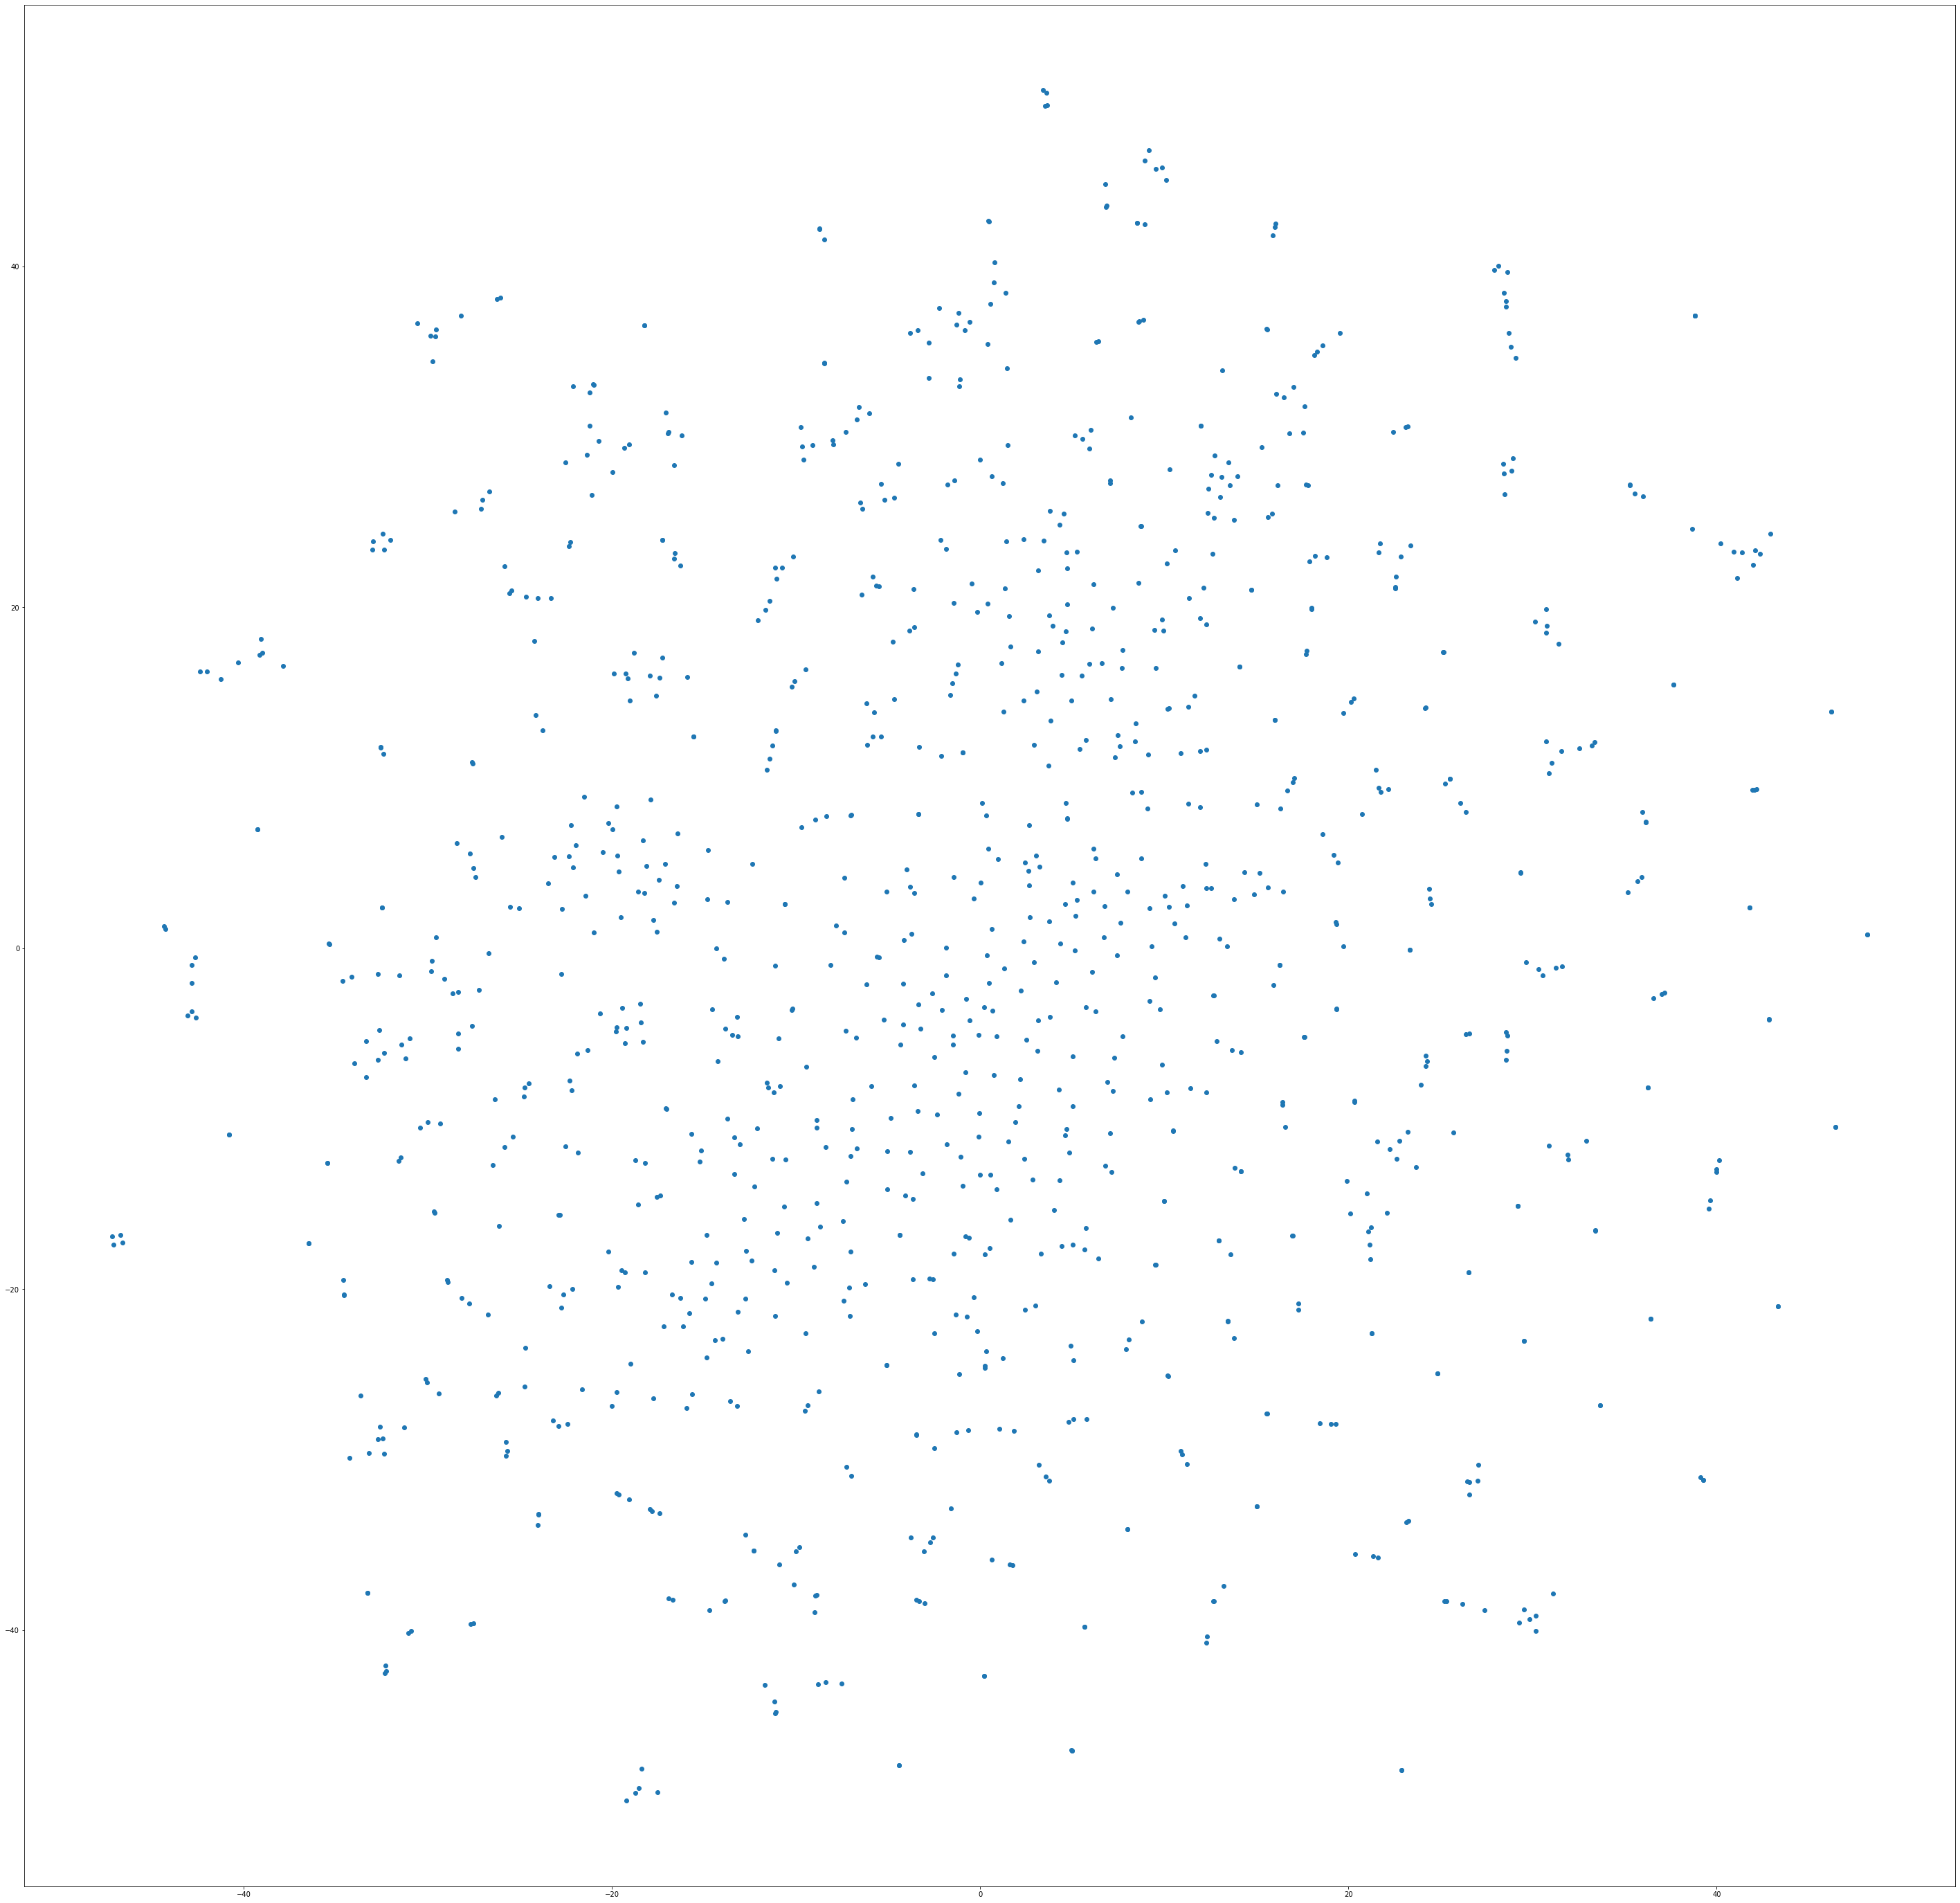

In [7]:
plt.figure(figsize=(50, 50))
plt.scatter(lwi["x"], lwi["y"])

In [8]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree

# Parameters
pixel_length = 1.25 / 400
margin = 1
movement = pixel_length
max_distance =  np.sqrt(2) * pixel_length * 401

def adjust_positions(lwi):
    """Moves overlapping rectangles apart using KDTree and angle-based adjustments"""
    new_lwi = lwi.copy(deep=True)

    # Convert DataFrame to NumPy for speed
    coords = new_lwi[["x", "y"]].values
    widths = (new_lwi["w"] * pixel_length).values
    heights = (new_lwi["h"] * pixel_length).values

    # Build KDTree and find overlapping pairs
    tree = KDTree(coords)
    neighbor_pairs = tree.query_pairs(r=max_distance)  # Only check close neighbors

    changes = np.zeros_like(coords)  # Store movement updates

    count = 0
    for i, j in neighbor_pairs:
        x1, y1 = coords[i]
        x2, y2 = coords[j]
        w1, h1 = widths[i], heights[i]
        w2, h2 = widths[j], heights[j]

        # Calculate the direction vector
        dx, dy = x1 - x2, y1 - y2

        # Calculate angle of overlap using atan2
        angle = np.arctan2(dy, dx)

        # Calculate overlap in X and Y directions
        overlap_x = abs(dx) < (w1 * margin / 2 + w2 * margin / 2)
        overlap_y = abs(dy) < (h1 * margin / 2 + h2 * margin / 2)

        if overlap_x and overlap_y:
            count += 1

            # Calculate movement distance based on overlap
            move_x = movement * np.cos(angle)
            move_y = movement * np.sin(angle)

            # Apply changes in both x and y directions
            changes[i] += [move_x, move_y]
            changes[j] -= [move_x, move_y]

    # Apply updates in batch
    coords += changes
    new_lwi[["x", "y"]] = coords

    return new_lwi, count

# Run until no more overlaps
count = 1
while count > 0:
    new_lwi, count = adjust_positions(lwi)
    lwi = new_lwi  # Update DataFrame
    print(f"Remaining overlaps: {count}")


Remaining overlaps: 738
Remaining overlaps: 736
Remaining overlaps: 735
Remaining overlaps: 730
Remaining overlaps: 726
Remaining overlaps: 720
Remaining overlaps: 717
Remaining overlaps: 716
Remaining overlaps: 710
Remaining overlaps: 710
Remaining overlaps: 706
Remaining overlaps: 705
Remaining overlaps: 698
Remaining overlaps: 690
Remaining overlaps: 692
Remaining overlaps: 680
Remaining overlaps: 682
Remaining overlaps: 668
Remaining overlaps: 676
Remaining overlaps: 670
Remaining overlaps: 666
Remaining overlaps: 663
Remaining overlaps: 655
Remaining overlaps: 653
Remaining overlaps: 642
Remaining overlaps: 643
Remaining overlaps: 636
Remaining overlaps: 631
Remaining overlaps: 633
Remaining overlaps: 627
Remaining overlaps: 620
Remaining overlaps: 619
Remaining overlaps: 608
Remaining overlaps: 611
Remaining overlaps: 604
Remaining overlaps: 601
Remaining overlaps: 602
Remaining overlaps: 588
Remaining overlaps: 582
Remaining overlaps: 584
Remaining overlaps: 573
Remaining overla

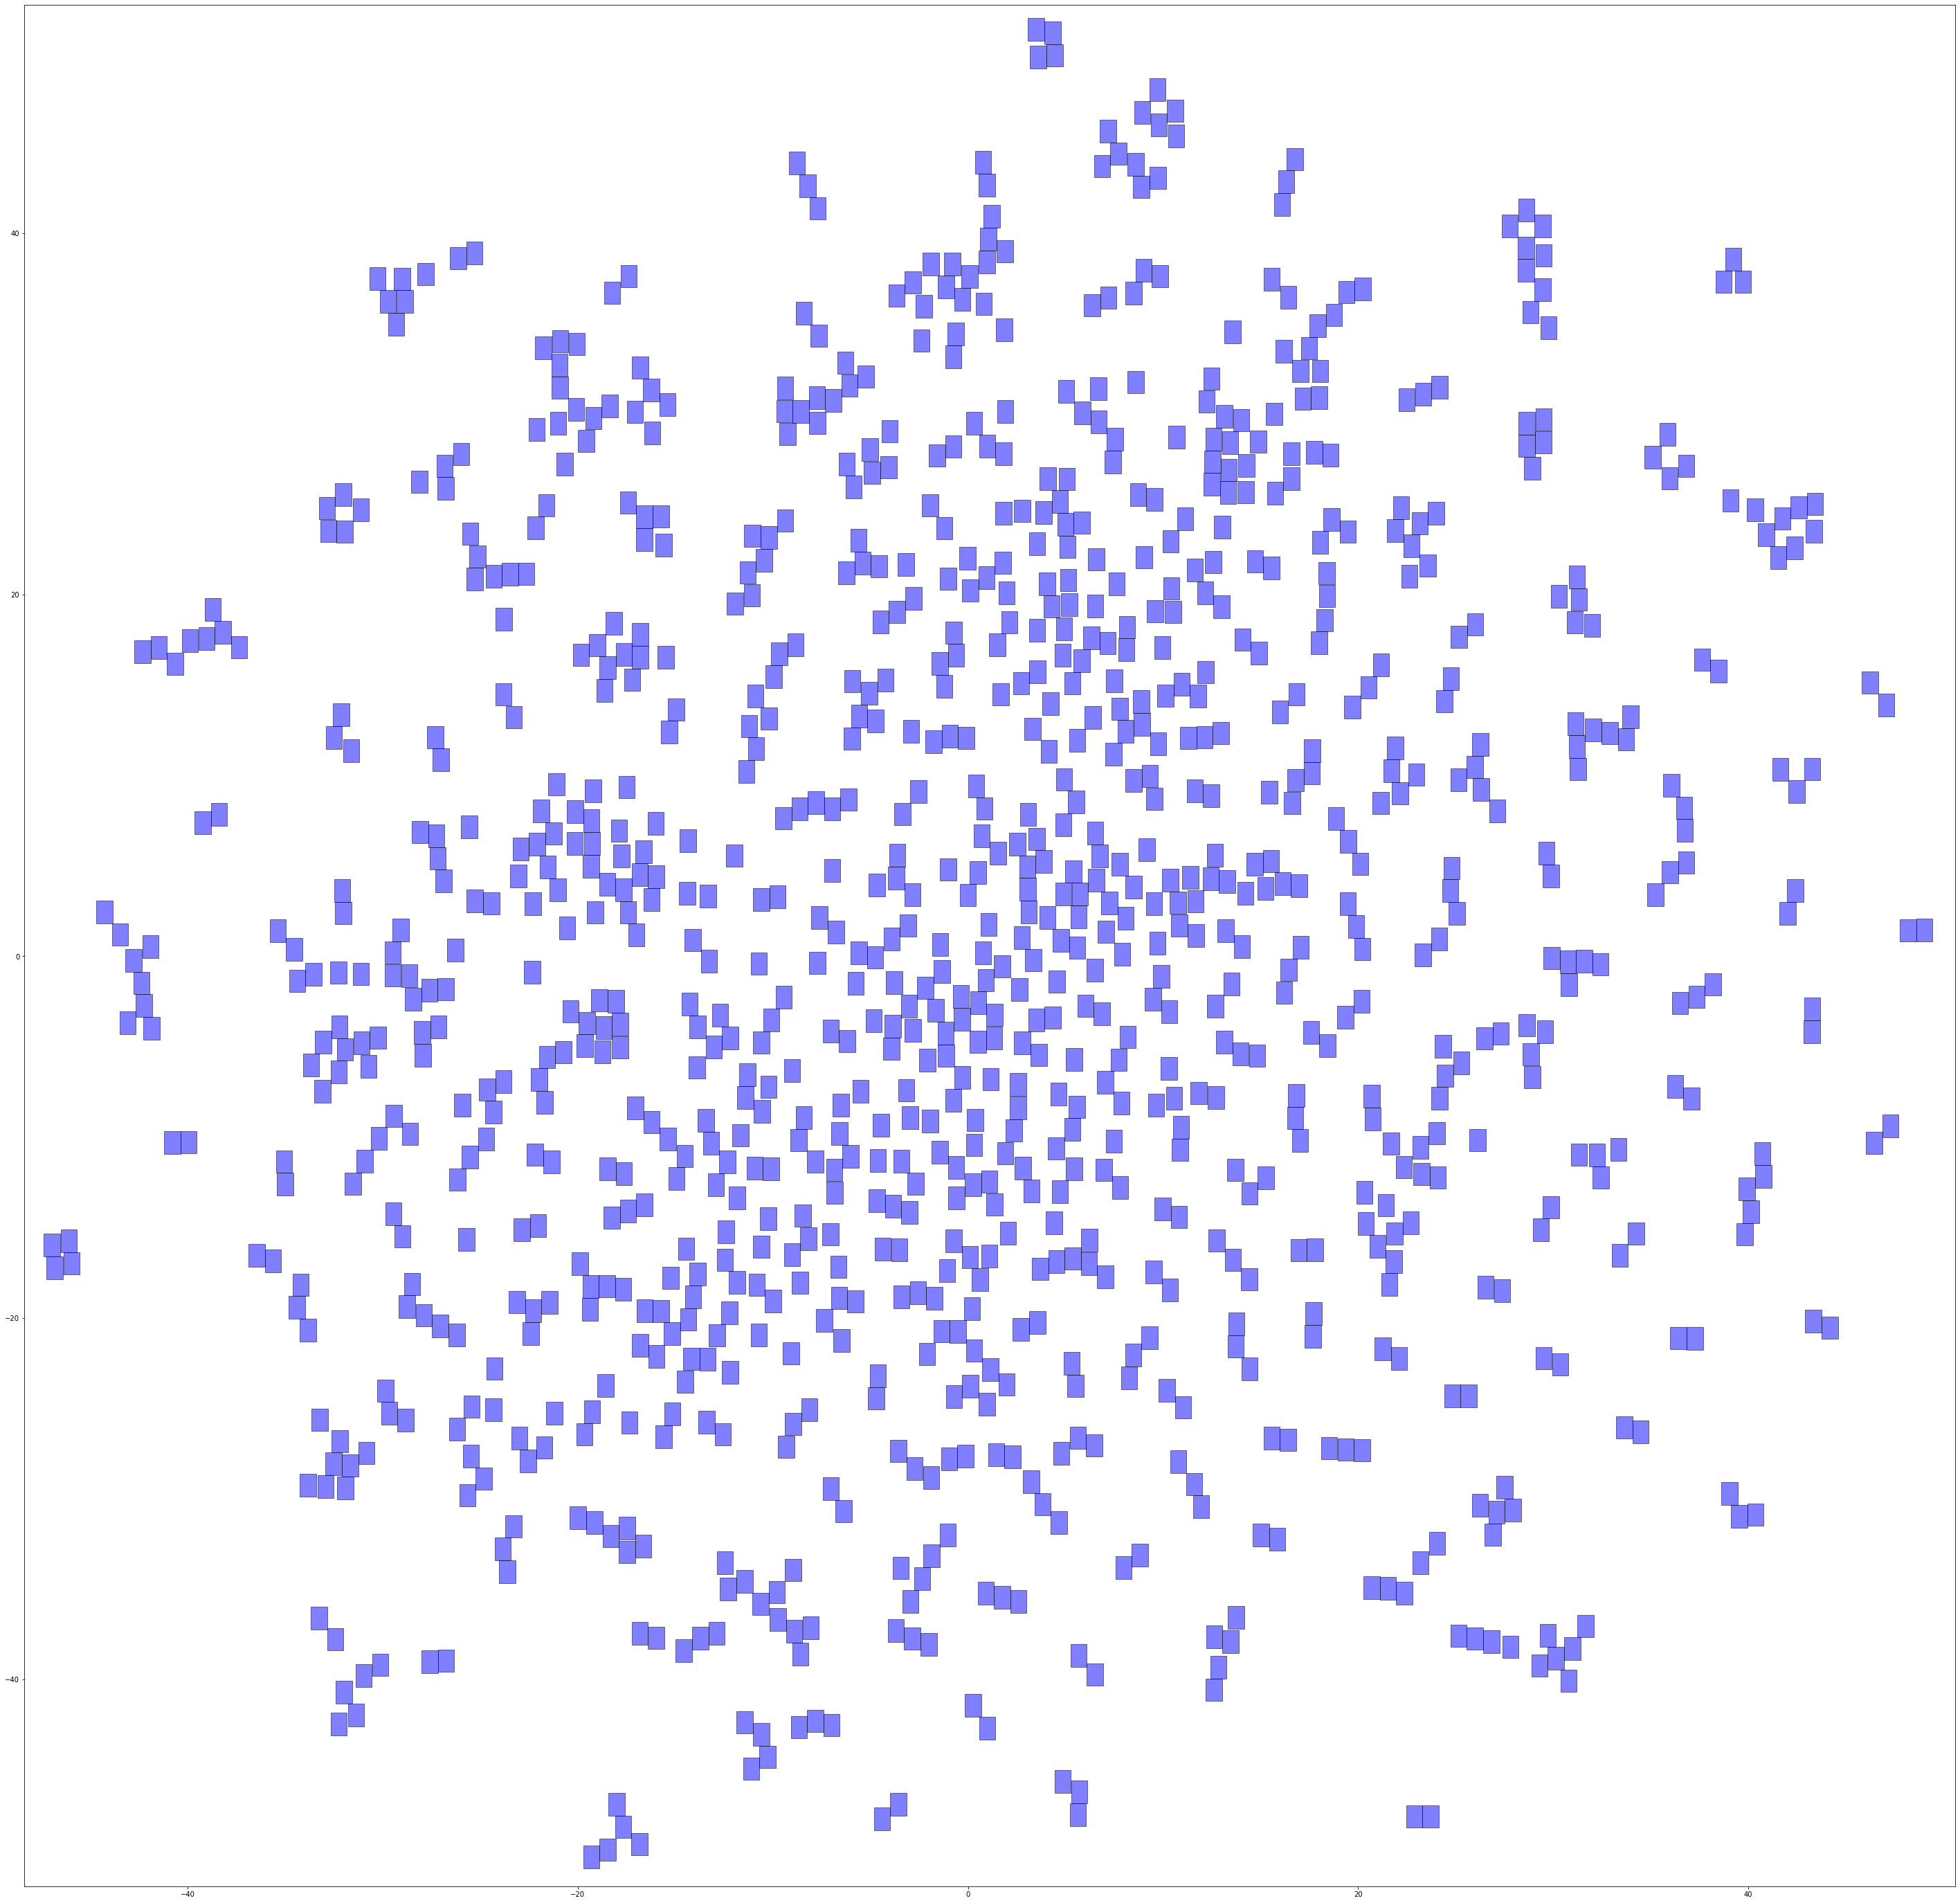

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

# Create a list of rectangle patches at each (x, y)
patches = [mpatches.Rectangle((x, y), pixel_length * w, pixel_length * h) for x, y, w, h in zip(lwi["x"], lwi["y"], lwi["w"], lwi["h"])]

fig, ax = plt.subplots(figsize=(50, 50))  # Adjust figure size as needed
collection = PatchCollection(patches, facecolor='blue', edgecolor='black', alpha=0.5)
ax.add_collection(collection)

# Set the limits to ensure all patches are visible
ax.set_xlim(min(lwi["x"]) - 1, max(lwi["x"]) + 2)
ax.set_ylim(min(lwi["y"]) - 1, max(lwi["y"]) + 2)
plt.show()



In [10]:
lwi.to_csv("site/data/final_locations.csv")